In [1]:
import pandas as pd
import itertools #Confusion Matrix
import string 
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('drugsComTrain_raw.tsv', sep='\t')

In [3]:
df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [4]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [5]:
df_train = df[(df['condition']=='Birth Control') | (df['condition']=='Depression') | (df['condition']=='High Blood Pressure')|(df['condition']=='Diabetes, Type 2')| (df['condition']=='Smoking Cessation')]



In [6]:
df.shape

(161297, 7)

In [7]:
df_train.shape

(44512, 7)

In [8]:
X = df_train.drop(['Unnamed: 0','drugName','rating','date','usefulCount'],axis=1)

### EDA

In [9]:
X.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Smoking Cessation       1780
Name: count, dtype: int64

In [10]:
X.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

In [11]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]
X_smoke = X[(X['condition']=='Smoking Cessation')]

Text(0.5, 1.0, 'Word cloud for Birth control')

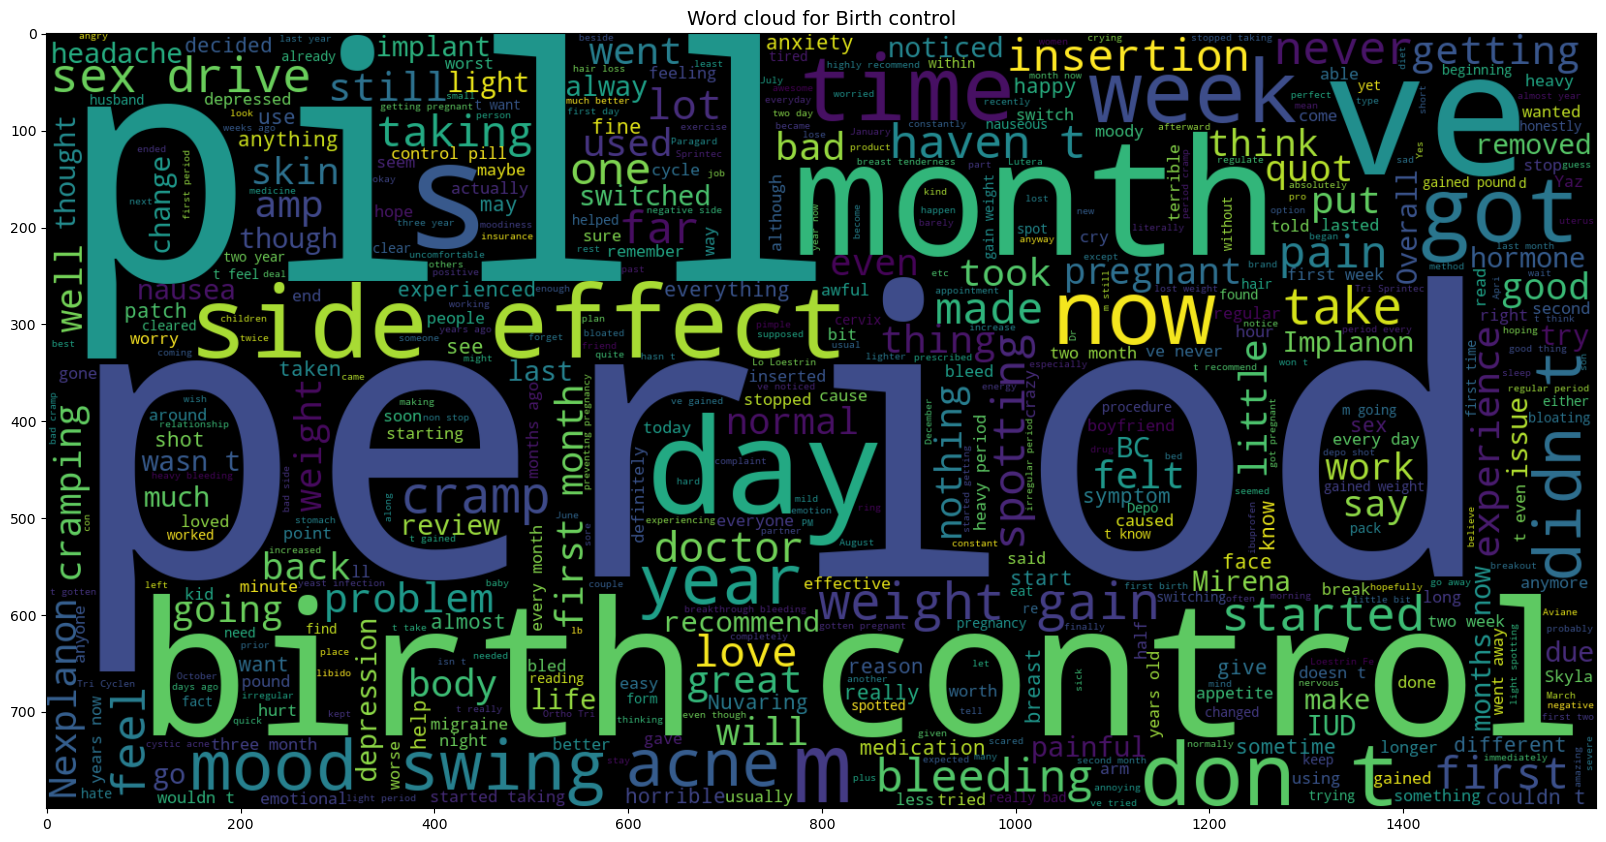

In [12]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_birth.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

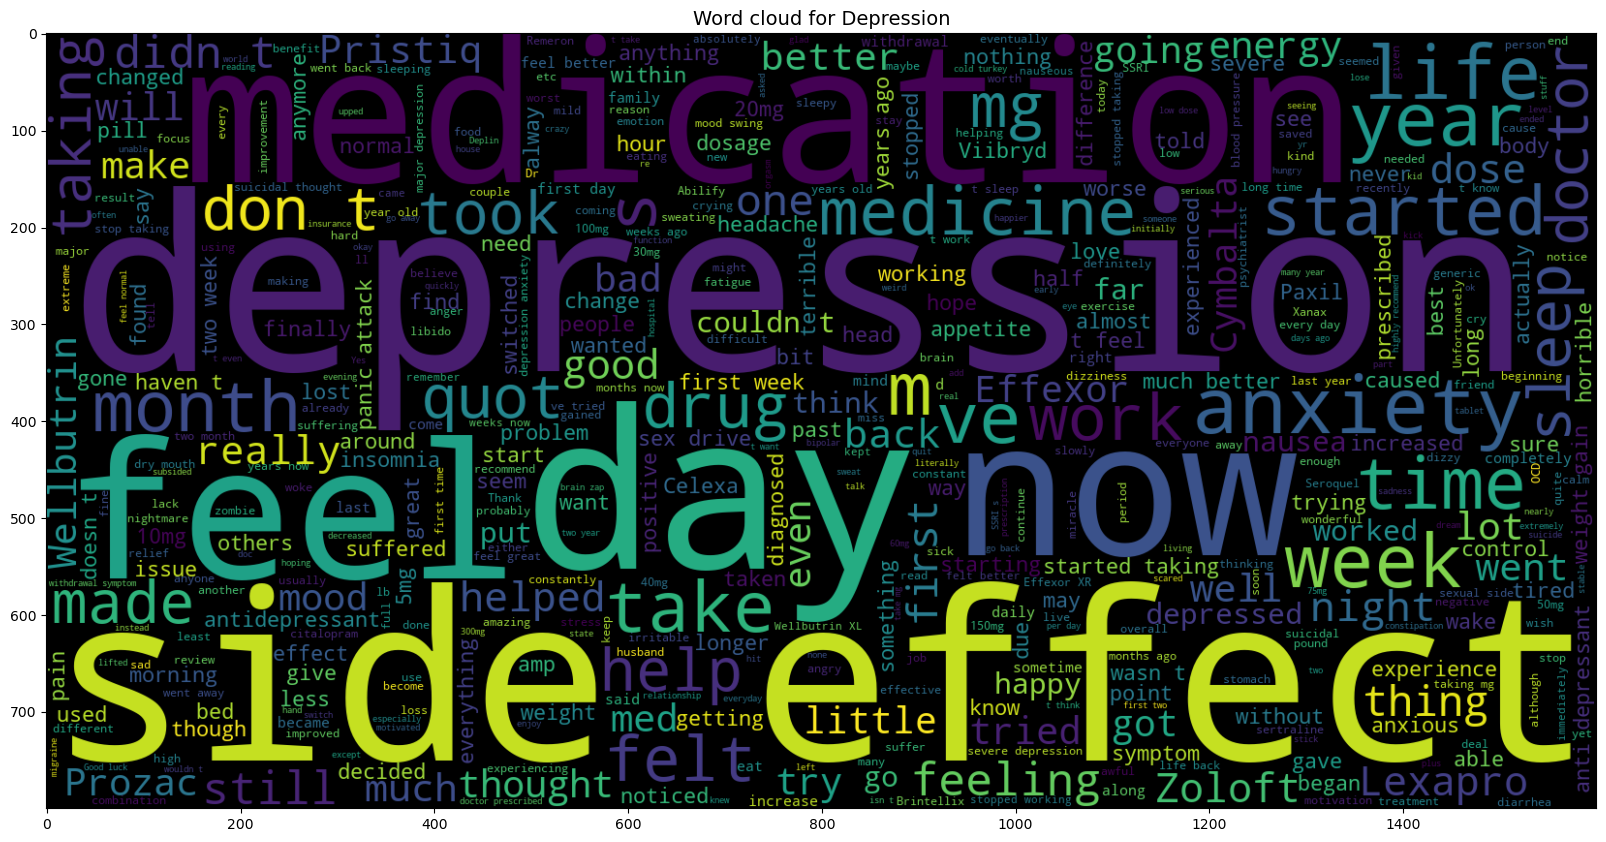

In [13]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=14)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

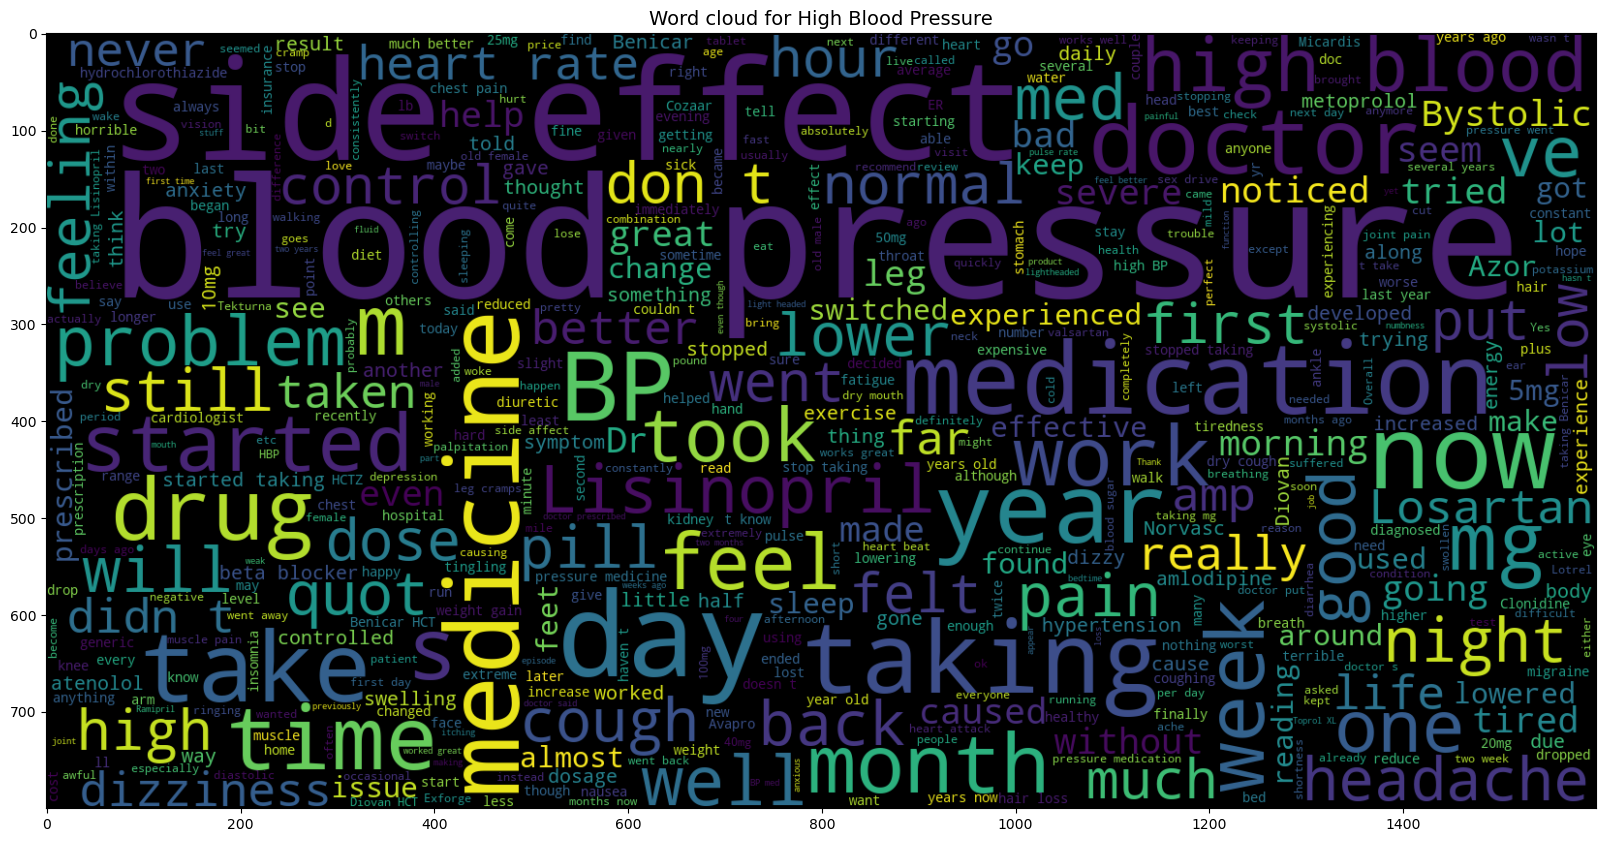

In [14]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes Type 2')

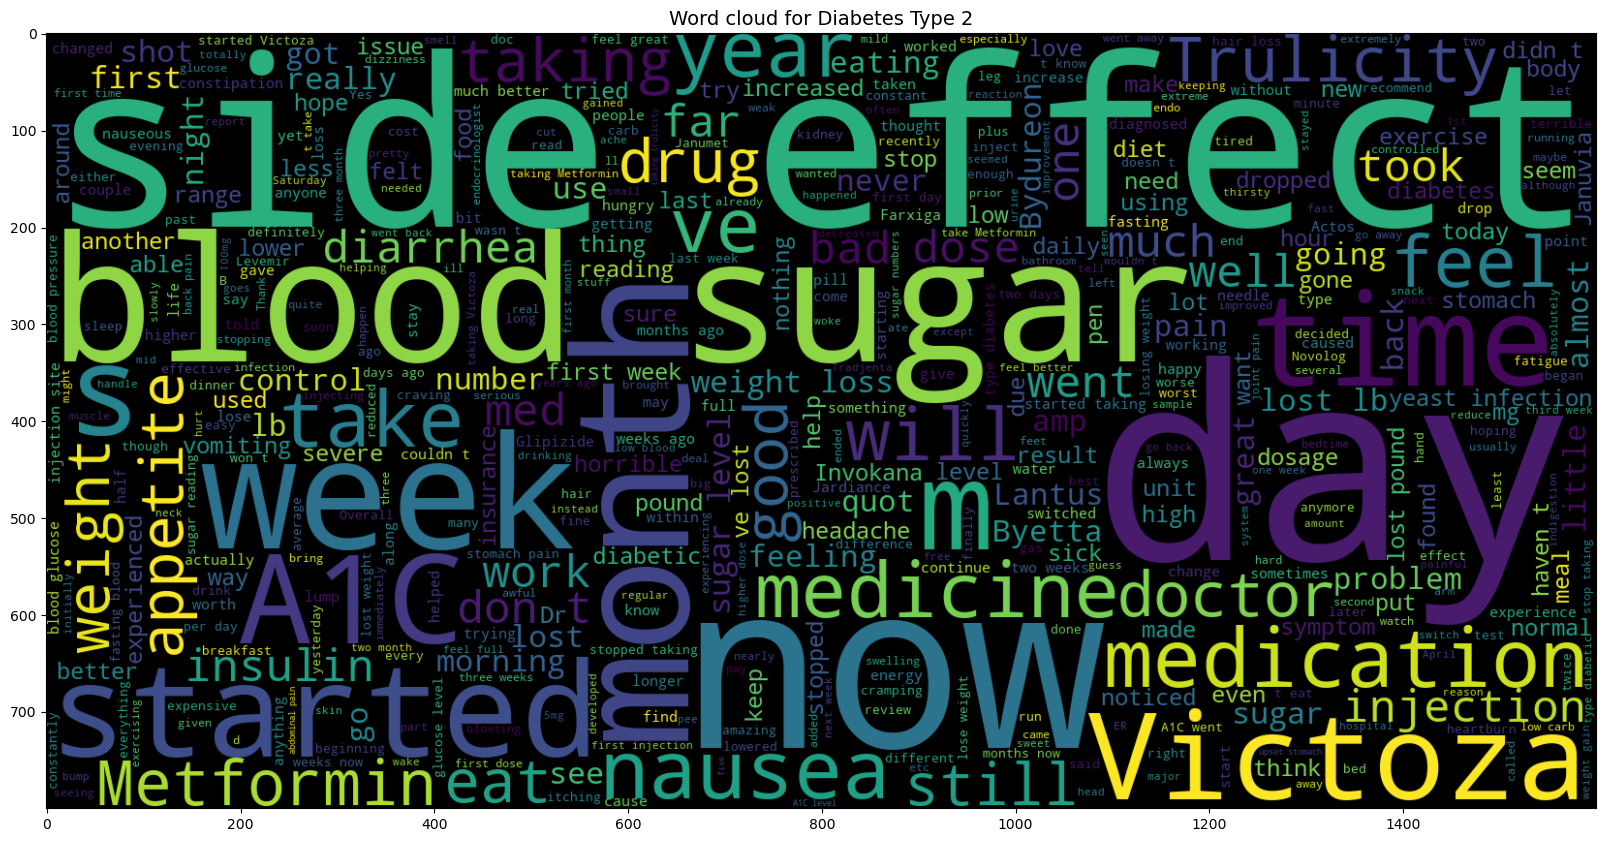

In [15]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes Type 2',fontsize=14)

Text(0.5, 1.0, 'Word cloud for Smoking Cessation')

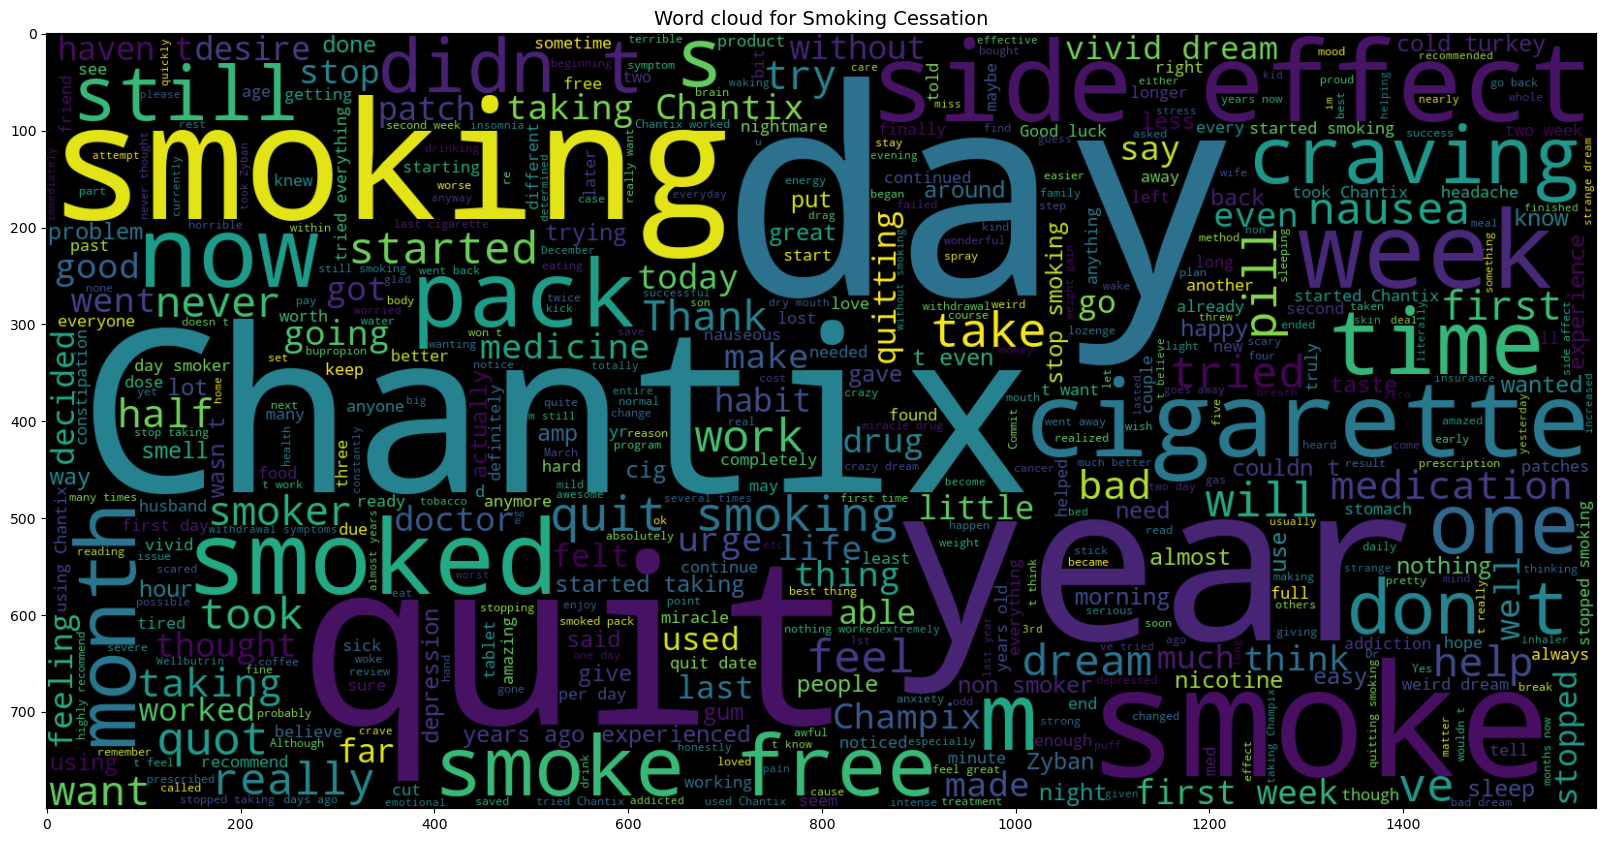

In [16]:
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1600 , height = 800).generate(" ".join(X_smoke.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Smoking Cessation',fontsize=14)

### Data Preprocessing

In [17]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [18]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [19]:
X.head()

condition                                             review
2   Birth Control  I used to take another oral contraceptive, whi...
3   Birth Control  This is my first time using any form of birth ...
9   Birth Control  I had been on the pill for many years. When my...
11     Depression  I have taken anti-depressants for years, with ...
14  Birth Control  Started Nexplanon 2 months ago because I have ...

In [20]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = stopwords.words('english')

porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

In [21]:
from bs4 import BeautifulSoup
import re

In [22]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop]
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [23]:
X['review_clean'] = X['review'].apply(review_to_words)

C:\Users\athar\AppData\Local\Temp\ipykernel_2184\2066199760.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [24]:
X.head()

condition                                             review  \
2   Birth Control  I used to take another oral contraceptive, whi...   
3   Birth Control  This is my first time using any form of birth ...   
9   Birth Control  I had been on the pill for many years. When my...   
11     Depression  I have taken anti-depressants for years, with ...   
14  Birth Control  Started Nexplanon 2 months ago because I have ...   

                                         review_clean  
2   used take another oral contraceptive pill cycl...  
3   first time using form birth control glad went ...  
9   pill many year doctor changed rx chateal effec...  
11  taken anti depressant year improvement mostly ...  
14  started nexplanon month ago minimal amount con...

In [25]:
#Creating features and Target Variable
X_feat=X['review_clean']
y=X['condition']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

In [27]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#This function prints and plots the confusion matrix.
#Normalization can be applied by setting `normalize=True`.
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Bag of Words

In [28]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [29]:
count_train

<35609x16448 sparse matrix of type '<class 'numpy.int64'>'
	with 1137027 stored elements in Compressed Sparse Row format>

### Machine Learning Model : Naive Bayes

accuracy:   0.968
Confusion matrix, without normalization


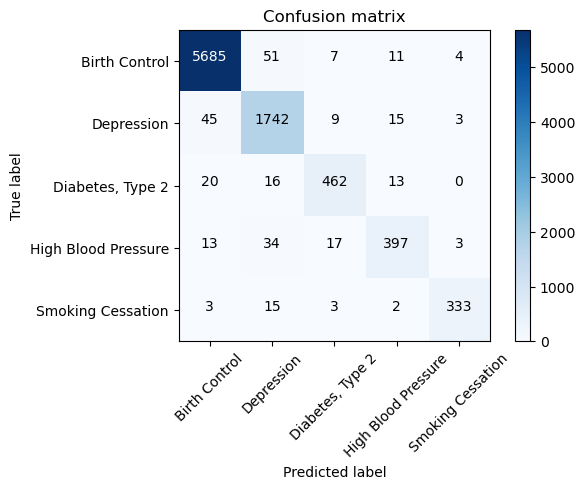

In [30]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

accuracy:   0.978
Confusion matrix, without normalization


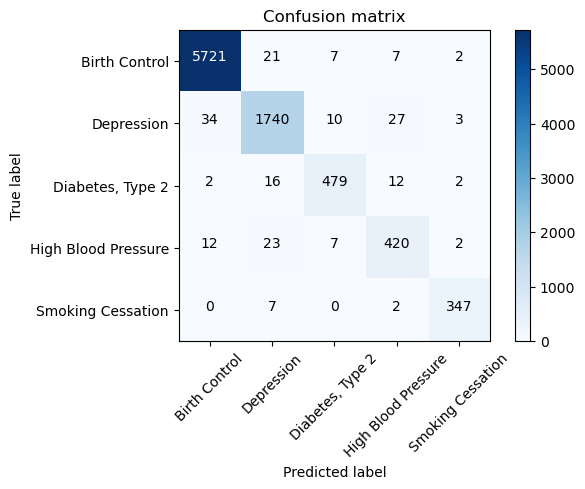

In [31]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

#### TFIDF

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)  #max_df is to remove 80% Frequent words
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

### Machine Learning Model : Naive Bayes 

accuracy:   0.913
Confusion matrix, without normalization


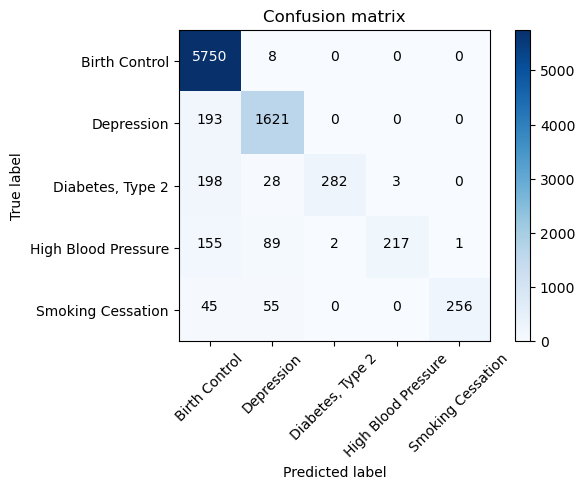

In [33]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

### Machine Learning Model TFIDF

accuracy:   0.982
Confusion matrix, without normalization


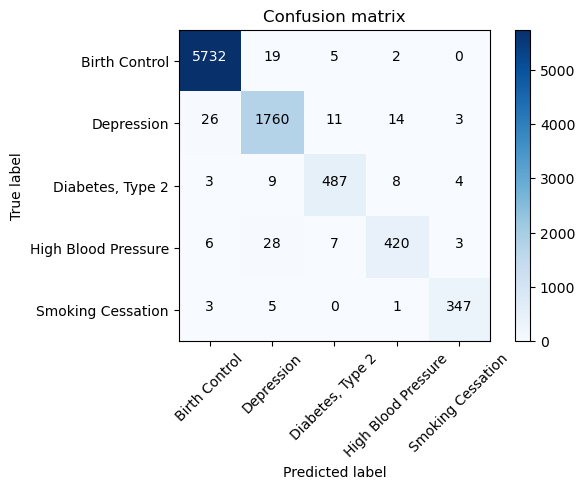

In [34]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

### TFIDF: Bigrams

In [35]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

accuracy:   0.984
Confusion matrix, without normalization


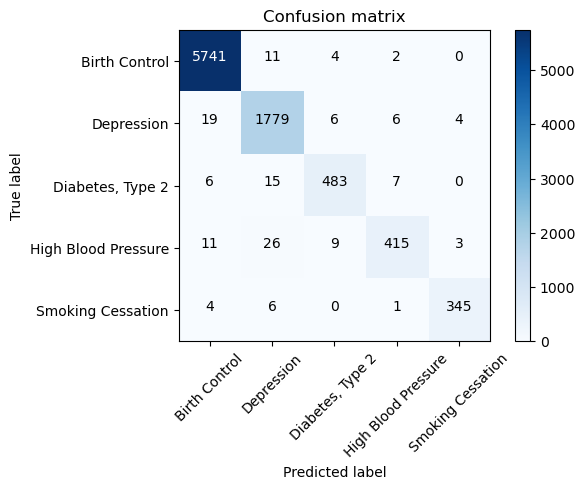

In [36]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

### TFIDF : Trigrams

accuracy:   0.984
Confusion matrix, without normalization


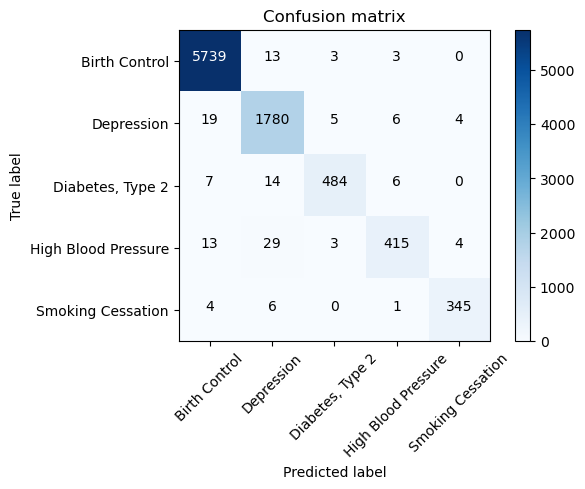

In [37]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

### Most important Features

In [38]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)



most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

Birth Control puked 0.5340135340767419
Birth Control tuck 0.5347553679042809
Birth Control tucked 0.5347553679042809
Birth Control come 0.5516761753481918
Birth Control retroverted 0.5718746441677127
Birth Control overlying 0.6169858123499133
Birth Control additive 0.714065988017203
Birth Control torment 0.8115554526761759
Birth Control commutative 1.3813456522309717
Birth Control friend 7.318494002889998


In [39]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression disconnected 0.5053119004211988
Depression disabling 0.5931198319148814
Depression similiar 0.7519283154528154
Depression dhea 0.7523908610094153
Depression simmering 0.8449550367288949
Depression assaulted 0.8604197464512916
Depression sulfur 1.063916872436179
Depression apartment 1.1927570331429016
Depression sick 1.3660593740253892
Depression alike 3.655365287970048


In [40]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure fda 0.5412912689015076
High Blood Pressure fe 0.5412912689015076
High Blood Pressure endometriosis 0.5633722965322615
High Blood Pressure forcibly 0.5872418188545354
High Blood Pressure endometerosis 0.6016608655292495
High Blood Pressure based 0.6245595134260028
High Blood Pressure enhances 0.6808715900854523
High Blood Pressure shaped 0.7484865148665046
High Blood Pressure fluvoxamine 0.763112081600896
High Blood Pressure forcing 0.9950869573773361


In [41]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 overdrive 0.3520855383243891
Diabetes, Type 2 vicotoza 0.371312689591304
Diabetes, Type 2 abstain 0.37651291977276274
Diabetes, Type 2 fluvoxamine 0.4668514673935114
Diabetes, Type 2 basis 0.4822843963384835
Diabetes, Type 2 pristiq 0.5312276514409509
Diabetes, Type 2 prison 0.6736249500270195
Diabetes, Type 2 operating 0.7099941822078001
Diabetes, Type 2 france 0.847789438990255
Diabetes, Type 2 preteen 2.8111112977003856


In [42]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Smoking Cessation')

Smoking Cessation shortens 0.34032060113376184
Smoking Cessation shorter 0.34032060113376184
Smoking Cessation sooooooooo 0.3495925380965814
Smoking Cessation sooooooooooo 0.3495925380965814
Smoking Cessation yhey 0.35014369381985133
Smoking Cessation ash 0.3662038436281619
Smoking Cessation ashamed 0.37664067425404085
Smoking Cessation ashlyan 0.37664067425404085
Smoking Cessation strange 0.8236924873015744
Smoking Cessation stuff 1.0058226542609285


### Sample Predictions

In [43]:
X.tail()

condition  \
161273        Birth Control   
161278     Diabetes, Type 2   
161286           Depression   
161290  High Blood Pressure   
161291        Birth Control   

                                                   review  \
161273  I have had the Nexplanon since Dec. 27, 2016 \...   
161278  I just got diagnosed with type 2. My doctor pr...   
161286  This is the third med I&#039;ve tried for anxi...   
161290  I have only been on Tekturna for 9 days. The e...   
161291  This would be my second month on Junel. I&#039...   

                                             review_clean  
161273  nexplanon since dec got first period end janua...  
161278  got diagnosed type doctor prescribed invokana ...  
161286  third med tried anxiety mild depression week h...  
161290  tekturna day effect immediate also calcium cha...  
161291  would second month junel birth control year ch...

accuracy:   0.982
Confusion matrix, without normalization


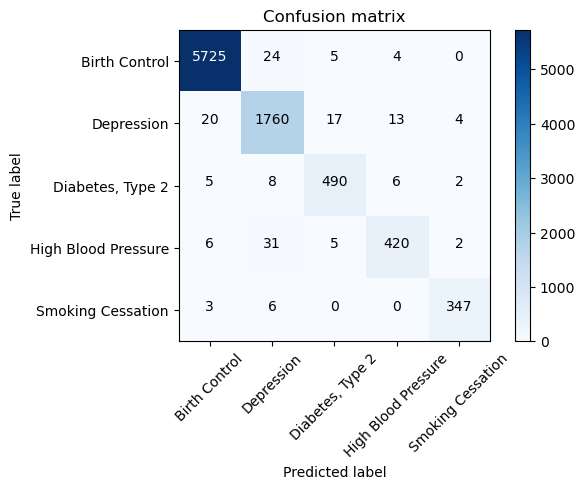

In [44]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure','Smoking Cessation'])

In [45]:
text =["I have only been on Tekturna for 9 days. The effect was immediate. I am also on a calcium channel blocker (Tiazac) and hydrochlorothiazide. I was put on Tekturna because of palpitations experienced with Diovan (ugly drug in my opinion, same company produces both however). The palpitations were pretty bad on Diovan, 24 hour monitor by EKG etc. After a few days of substituting Tekturna for Diovan, there are no more palpitations."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'High Blood Pressure'

In [46]:
text =["This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap."]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Depression'

In [47]:
text =["I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me"]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Diabetes, Type 2'

In [48]:
new_df = pd.read_csv('drugsComTest_raw.tsv', sep='\t')

In [49]:
new_df.head(40)

Unnamed: 0               drugName                     condition  \
0       163740            Mirtazapine                    Depression   
1       206473             Mesalamine  Crohn's Disease, Maintenance   
2       159672                Bactrim       Urinary Tract Infection   
3        39293               Contrave                   Weight Loss   
4        97768        Cyclafem 1 / 35                 Birth Control   
5       208087                Zyclara                     Keratosis   
6       215892                 Copper                 Birth Control   
7       169852          Amitriptyline           Migraine Prevention   
8        23295              Methadone             Opiate Withdrawal   
9        71428                 Levora                 Birth Control   
10      196802             Paroxetine                   Hot Flashes   
11       31947             Miconazole       Vaginal Yeast Infection   
12        4907                 Belviq                   Weight Loss   
13       66736               Seroquel       Schizoaffective Disorde   
14       97013                 Ambien                      Insomnia   
15      213376                Nuvigil                    Narcolepsy   
16      151674                Chantix             Smoking Cessation   
17       33173  Microgestin Fe 1 / 20                          Acne   
18       30401               Klonopin               Bipolar Disorde   
19      152490          Ciprofloxacin       Urinary Tract Infection   
20      231397              Trazodone                      Insomnia   
21       38116              EnteraGam      Irritable Bowel Syndrome   
22      102969           Aripiprazole               Bipolar Disorde   
23       12626           Cyclosporine    Keratoconjunctivitis Sicca   
24      190527             Oxybutynin                 Hyperhidrosis   
25      229975             Lurasidone               Bipolar Disorde   
26      173391             Clonazepam                 Panic Disorde   
27       35608             Ciclopirox     Onychomycosis, Fingernail   
28      187230         Sodium oxybate                    Narcolepsy   
29      211675            Lamotrigine               Bipolar Disorde   
30       79865      Blisovi Fe 1 / 20                 Birth Control   
31       27607             Ivermectin                       Rosacea   
32      207923  Suprep Bowel Prep Kit             Bowel Preparation   
33      156919               Movantik    Constipation, Drug Induced   
34       77164             Lorcaserin                           NaN   
35      101149                  Actos              Diabetes, Type 2   
36      178004             Duloxetine                          Pain   
37       60341               NuvaRing                 Birth Control   
38      141462           Escitalopram                    Depression   
39      133539            Tesamorelin                 Lipodystrophy   

                                               review  rating  \
0   "I&#039;ve tried a few antidepressants over th...    10.0   
1   "My son has Crohn&#039;s disease and has done ...     8.0   
2                       "Quick reduction of symptoms"     9.0   
3   "Contrave combines drugs that were used for al...     9.0   
4   "I have been on this birth control for one cyc...     9.0   
5   "4 days in on first 2 weeks.  Using on arms an...     4.0   
6   "I&#039;ve had the copper coil for about 3 mon...     6.0   
7   "This has been great for me. I&#039;ve been on...     9.0   
8   "Ive been on Methadone for over ten years and ...     7.0   
9   "I was on this pill for almost two years. It d...     2.0   
10  "Holy Hell is exactly how I feel. I had been t...     1.0   
11  "Honestly its day one on the 3 day treatment. ...     6.0   
12  "This is a waste of money.  Did not curb my ap...     1.0   
13                 "No problems, watch what you eat."    10.0   
14  "Ditto on rebound sleepless when discontinued....     2.0   
15  "A doctor in the ER prescribed me 200 mg of Pr..

In [50]:
new_df.loc[new_df['condition']=='Smoking Cessation']

Unnamed: 0          drugName          condition  \
16         151674           Chantix  Smoking Cessation   
102         62652       Nicoderm CQ  Smoking Cessation   
124        225258         Bupropion  Smoking Cessation   
499        151470           Chantix  Smoking Cessation   
502        200490       Varenicline  Smoking Cessation   
606        225323         Bupropion  Smoking Cessation   
667        200112       Varenicline  Smoking Cessation   
692        151909           Chantix  Smoking Cessation   
720        200261       Varenicline  Smoking Cessation   
730        151700           Chantix  Smoking Cessation   
854        114257          Nicotine  Smoking Cessation   
947        151474           Chantix  Smoking Cessation   
991        151447           Chantix  Smoking Cessation   
1157       200714       Varenicline  Smoking Cessation   
1455       152116           Chantix  Smoking Cessation   
1528       200443       Varenicline  Smoking Cessation   
1547       199639       Varenicline  Smoking Cessation   
1689       200836       Varenicline  Smoking Cessation   
1846       200180       Varenicline  Smoking Cessation   
1918       200616       Varenicline  Smoking Cessation   
2204       200701       Varenicline  Smoking Cessation   
2238       151344           Chantix  Smoking Cessation   
2261       151413           Chantix  Smoking Cessation   
2758       151993           Chantix  Smoking Cessation   
2893       151753           Chantix  Smoking Cessation   
2908       199717       Varenicline  Smoking Cessation   
2938       199984       Varenicline  Smoking Cessation   
3067       151907           Chantix  Smoking Cessation   
3080       200445       Varenicline  Smoking Cessation   
3206       151982           Chantix  Smoking Cessation   
3342       151496           Chantix  Smoking Cessation   
3352       203610             Zyban  Smoking Cessation   
3463       196115  Nicotrol Inhaler  Smoking Cessation   
3552       151373           Chantix  Smoking Cessation   
3656       199731       Varenicline  Smoking Cessation   
3942       151627           Chantix  Smoking Cessation   
3988       200148       Varenicline  Smoking Cessation   
4180       200019       Varenicline  Smoking Cessation   
4228       199645       Varenicline  Smoking Cessation   
4386       152033           Chantix  Smoking Cessation   
4405       200729       Varenicline  Smoking Cessation   
4608       222251         Nicorette  Smoking Cessation   
4715       151314           Chantix  Smoking Cessation   
4729       200259       Varenicline  Smoking Cessation   
4755       151415           Chantix  Smoking Cessation   
4853       200349       Varenicline  Smoking Cessation   
4873       151433           Chantix  Smoking Cessation   
4974       200086       Varenicline  Smoking Cessation   
4988       225278         Bupropion  Smoking Cessation   
5075       151481           Chantix  Smoking Cessation   
5257       224970         Bupropion  Smoking Cessation   
5506       224948         Bupropion  Smoking Cessation   
5548       200662       Varenicline  Smoking Cessation   
5613       151476           Chantix  Smoking Cessation   
5644       114319          Nicotine  Smoking Cessation   
5679       200143       Varenicline  Smoking Cessation   
5680       200586       Varenicline  Smoking Cessation   
5721       199899       Varenicline  Smoking Cessation   
5931       203593             Zyban  Smoking Cessation   
6020       200006       Varenicline  Smoking Cessation   
6030       200186       Varenicline  Smoking Cessation   
6203       199844       Varenicline  Smoking Cessation   
6263       199667       Varenicline  Smoking Cessation   
6451       222259         Nicorette  Smoking Cessation   
6489       200620       Varenicline  Smoking Cessation   
6523       199968       Varenicline  Smoking Cessation   
6586       199902       Varenicline  Smoking Cessation   
6587       151333           Chantix  Smoking Cessation   
6604 

In [51]:
text = [new_df.review[28275]]
test = tfidf_vectorizer.transform(text)
pred1=pass_tf.predict(test)[0]
pred1

'Smoking Cessation'